In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.optim import Optimizer
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

100.0%
100.0%
100.0%
100.0%


tensor(5)


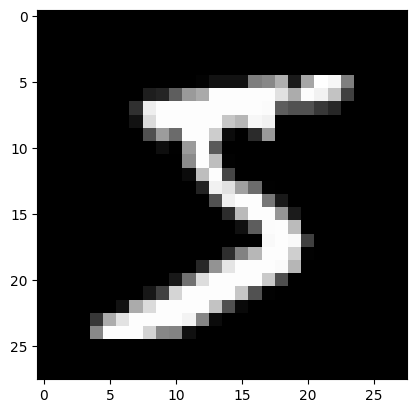

In [3]:
train_data, test_data = datasets.MNIST('data', train=True, download=True), datasets.MNIST('data', train=False, download=True)
x_train = train_data.data.view(-1, 28*28).float() / 255.0
y_train = train_data.targets
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# # Define the model as a subclass of nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.w = nn.Parameter(torch.randn(input_dim, num_classes))

    def forward(self, x):
        return x @ self.w

class DummySGD(Optimizer):
    def __init__(self, params, lr=0.1):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr)
        super(DummySGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                p.data.add_(-group['lr'], d_p)
        return loss
        
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        # Initialize state for each parameter
        self.state = {
            p: {"m": torch.zeros_like(p.data), "v": torch.zeros_like(p.data), "t": 0}
            for p in self.params
        }
        
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            state = self.state[p]
            state["t"] += 1
            t = state["t"]
            grad = p.grad.data

            # Update biased first and second moment estimates
            state["m"].mul_(self.beta1).add_(grad, alpha=1 - self.beta1)
            state["v"].mul_(self.beta2).addcmul_(grad, grad, value=1 - self.beta2)

            m_hat = state["m"] / (1 - self.beta1 ** t)
            v_hat_current = state["v"] / (1 - self.beta2 ** t)        
            if "v_hat" not in state:
                state["v_hat"] = v_hat_current.clone()
            else:
                state["v_hat"] = torch.max(state["v_hat"], v_hat_current)

            p.data.addcdiv_(m_hat, state["v_hat"].sqrt().add_(self.eps), value=-self.lr)

        return None
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()


def F_alpha_loss(model, x, target, alpha):
    logits = model(x) # (batch_size, num_classes)
    
    # we substract max_logits from exponential and then add them back for numerical stability    
    max_logits = logits.max(dim=1, keepdim=True).values
    log_sum_exp = max_logits + (logits - max_logits).exp().sum(dim=1, keepdim=True).log() # (batch_size, 1)

    labels = target.unsqueeze(1) # (batch_size, 1)
    y_train = torch.zeros_like(logits).scatter(1, labels, 1) # (batch_size, num_classes)
    subtract_term = (y_train * logits).sum(dim=1, keepdim=True) # (batch_size, 1)

    loss_data = torch.mean(log_sum_exp - subtract_term) # scalar

    alpha_term = 0.5 * alpha * torch.sum(model.w ** 2)

    return loss_data + alpha_term

In [4]:
from tqdm import tqdm


def test(model, val_loader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            predictions = logits.argmax(dim=1)
            total += y_batch.size(0)
            correct += (predictions == y_batch).sum().item()

    return correct / total


def train(model, train_loader, alpha, optimizer, optimizer_params, val_loader,
          num_epochs=10):
    model.to(device)
    model.train()
    opt = optimizer(model.parameters(), **optimizer_params)
    epoch_losses = []
    accuracies = []

    for _ in tqdm(range(num_epochs)):
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            opt.zero_grad()
            loss = F_alpha_loss(model, x_batch, y_batch, alpha)
            loss.backward()
            opt.step()
            running_loss += loss.item()
        
        avg_epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)
        acc = test(model, val_loader)
        accuracies.append(acc)

    return model, accuracies, epoch_losses

In [5]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm  
from torch.utils.data import DataLoader, TensorDataset

def solve_bilevel(alpha_range,
                   train_data,
                   val_loader,
                   optimizer,
                   optimizer_params,
                   num_epochs=10,
                   batch_size=64):

    d_alpha_accuracy = {}
    d_alpha_losses = {}
    best_alpha = None
    best_acc = 0
    best_model = None

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    input_dim = train_data.tensors[0].shape[1]
    num_classes = len(np.unique(train_data.tensors[1].numpy()))
    print("here", input_dim, num_classes)
    for alpha in alpha_range:
        print(f'Alpha: {alpha}')
        model = LogisticRegression(input_dim, num_classes)
        # model = LogisticRegression()
        model, accuracies, losses = train(model, train_loader, alpha, optimizer, optimizer_params, val_loader, num_epochs)        
        
        d_alpha_losses[alpha] = losses
        d_alpha_accuracy[alpha] = accuracies        

        acc = test(model, val_loader)
        print(f'Accuracy: {acc}')

        if acc > best_acc:
            best_acc = acc
            best_alpha = alpha
            best_model = model
    
    print(f'Best alpha: {best_alpha}, Best accuracy: {best_acc}')
    return best_alpha, best_acc, best_model, d_alpha_losses, d_alpha_accuracy


def generate_plots(alpha_range, num_epochs, d_alpha_losses, d_alpha_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
    # colors = cm.Blues(np.linspace(0.2, 0.9, len(alpha_range)))
    epochs_range = list(range(num_epochs))    
    for alpha in alpha_range:    
        # \u03b1 for symbol alpha
        axes[0].plot(epochs_range, d_alpha_losses[alpha], label=f'α = {alpha}', marker = "o", linewidth = 2)#, color=color)
        axes[1].plot(epochs_range, d_alpha_accuracy[alpha], label=f'α = {alpha}', marker = "o", linewidth = 2)#, color=color)

    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].set_title('Testing Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)


    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# ADAM

In [6]:
# Adam
ALPHA_RANGE = [0.0001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2]
# ALPHA_RANGE = [0.001]
NUM_EPOCHS = 30
OPTIMIZER_PARAMS = {"lr": 0.001, "betas": (0.9, 0.999), "eps": 1e-8}
BATCH_SIZE = 64
TRAIN_VAL_SPLIT_RATIO = 0.8
OPTIMIZER = Adam

In [7]:

train_data = TensorDataset(x_train, y_train)
print(train_data.tensors[0].shape[1])
train_size = int(TRAIN_VAL_SPLIT_RATIO * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])
# make train data dataset again
train_data = TensorDataset(train_data.dataset.tensors[0], train_data.dataset.tensors[1])

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

best_alpha_adam, best_acc_adam, best_model_adam, d_alpha_losses_adam, d_alpha_accuracy_adam = solve_bilevel(ALPHA_RANGE, train_data, val_loader, OPTIMIZER, OPTIMIZER_PARAMS, NUM_EPOCHS, BATCH_SIZE)

784
here 784 10
Alpha: 0.0001


100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


Accuracy: 0.8855833333333333
Alpha: 0.005


100%|██████████| 30/30 [00:48<00:00,  1.60s/it]


Accuracy: 0.9035
Alpha: 0.01


100%|██████████| 30/30 [00:46<00:00,  1.55s/it]


Accuracy: 0.89725
Alpha: 0.025


100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


Accuracy: 0.88525
Alpha: 0.05


100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


Accuracy: 0.8720833333333333
Alpha: 0.1


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


Accuracy: 0.8574166666666667
Alpha: 0.2


100%|██████████| 30/30 [00:48<00:00,  1.61s/it]

Accuracy: 0.8394166666666667
Best alpha: 0.005, Best accuracy: 0.9035


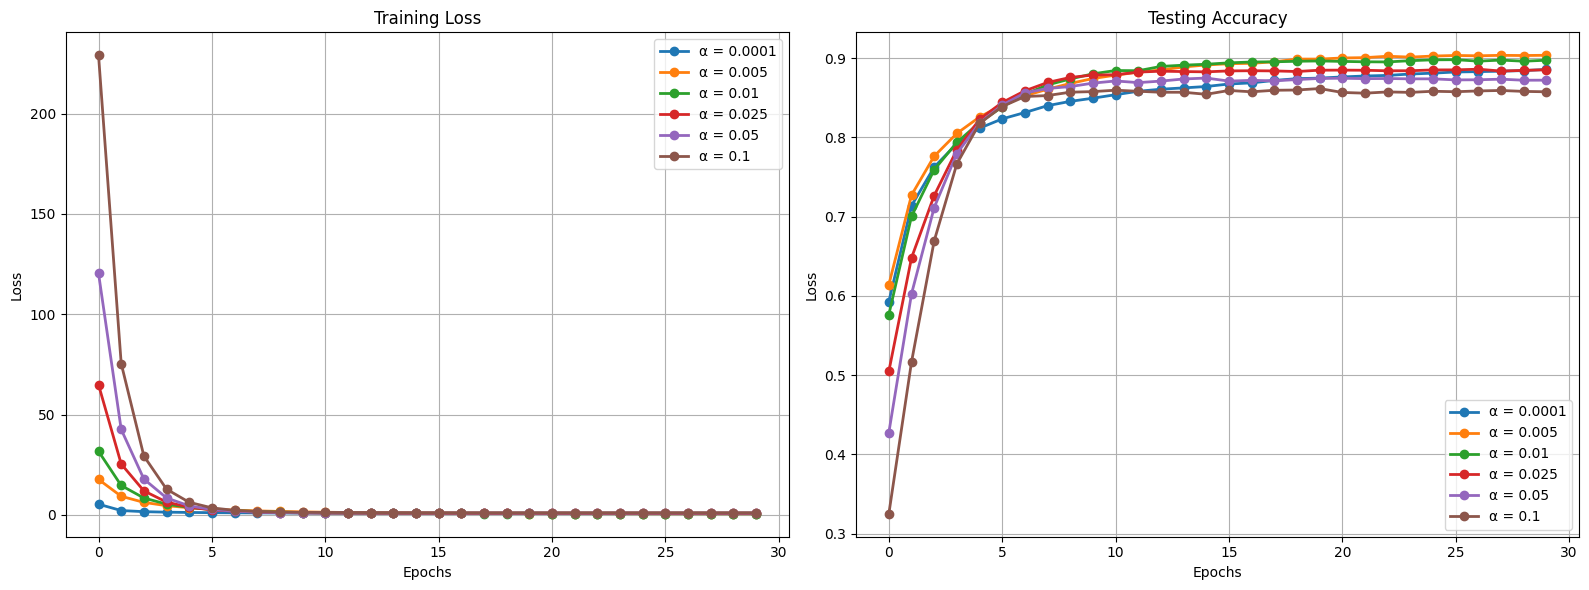

In [8]:
generate_plots(ALPHA_RANGE[:-1], NUM_EPOCHS, d_alpha_losses_adam, d_alpha_accuracy_adam)

# SGD

In [9]:
# Adam
ALPHA_RANGE = [0.0001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2]
# ALPHA_RANGE = [0.005]
NUM_EPOCHS = 30
OPTIMIZER_PARAMS = {"lr": 0.1}
BATCH_SIZE = 64
TRAIN_VAL_SPLIT_RATIO = 0.8
OPTIMIZER = DummySGD

In [10]:

train_data = TensorDataset(x_train, y_train)
print(train_data.tensors[0].shape[1])
train_size = int(TRAIN_VAL_SPLIT_RATIO * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])
# make train data dataset again
train_data = TensorDataset(train_data.dataset.tensors[0], train_data.dataset.tensors[1])

val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

best_alpha_sgd, best_acc_sgd, best_model_sgd, d_alpha_losses_sgd, d_alpha_accuracy_sgd = solve_bilevel(ALPHA_RANGE, train_data, val_loader, OPTIMIZER, OPTIMIZER_PARAMS, NUM_EPOCHS, BATCH_SIZE)

784
here 784 10
Alpha: 0.0001


  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_23724\3309800105.py:30: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\python_arg_parser.cpp:1661.)
  p.data.add_(-group['lr'], d_p)
100%|██████████| 30/30 [00:44<00:00,  1.48s/it]


Accuracy: 0.915
Alpha: 0.005


100%|██████████| 30/30 [00:46<00:00,  1.54s/it]


Accuracy: 0.9068333333333334
Alpha: 0.01


100%|██████████| 30/30 [00:46<00:00,  1.55s/it]


Accuracy: 0.8983333333333333
Alpha: 0.025


100%|██████████| 30/30 [00:45<00:00,  1.52s/it]


Accuracy: 0.8795
Alpha: 0.05


100%|██████████| 30/30 [00:46<00:00,  1.53s/it]


Accuracy: 0.8686666666666667
Alpha: 0.1


100%|██████████| 30/30 [00:45<00:00,  1.52s/it]


Accuracy: 0.85025
Alpha: 0.2


100%|██████████| 30/30 [00:46<00:00,  1.55s/it]

Accuracy: 0.8139166666666666
Best alpha: 0.0001, Best accuracy: 0.915


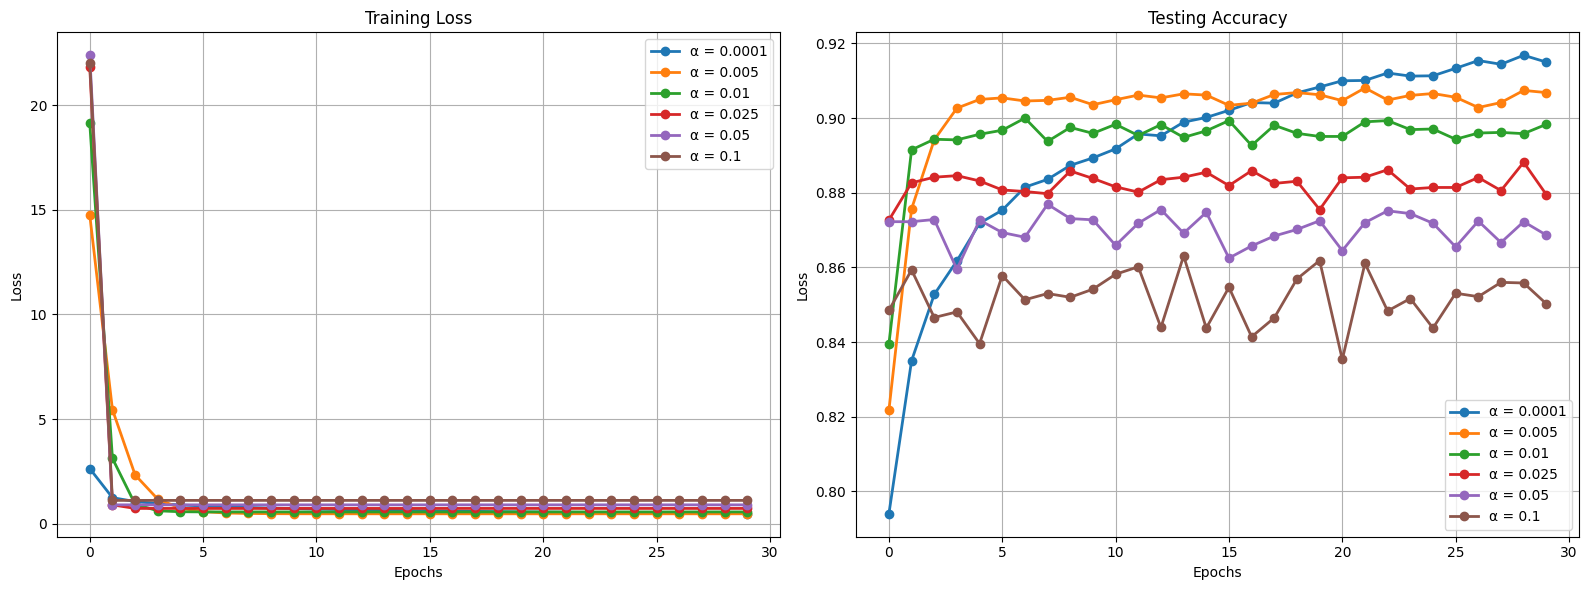

In [11]:
generate_plots(ALPHA_RANGE[:-1], NUM_EPOCHS, d_alpha_losses_sgd, d_alpha_accuracy_sgd)

# BEST SGD vs BEST ADAM

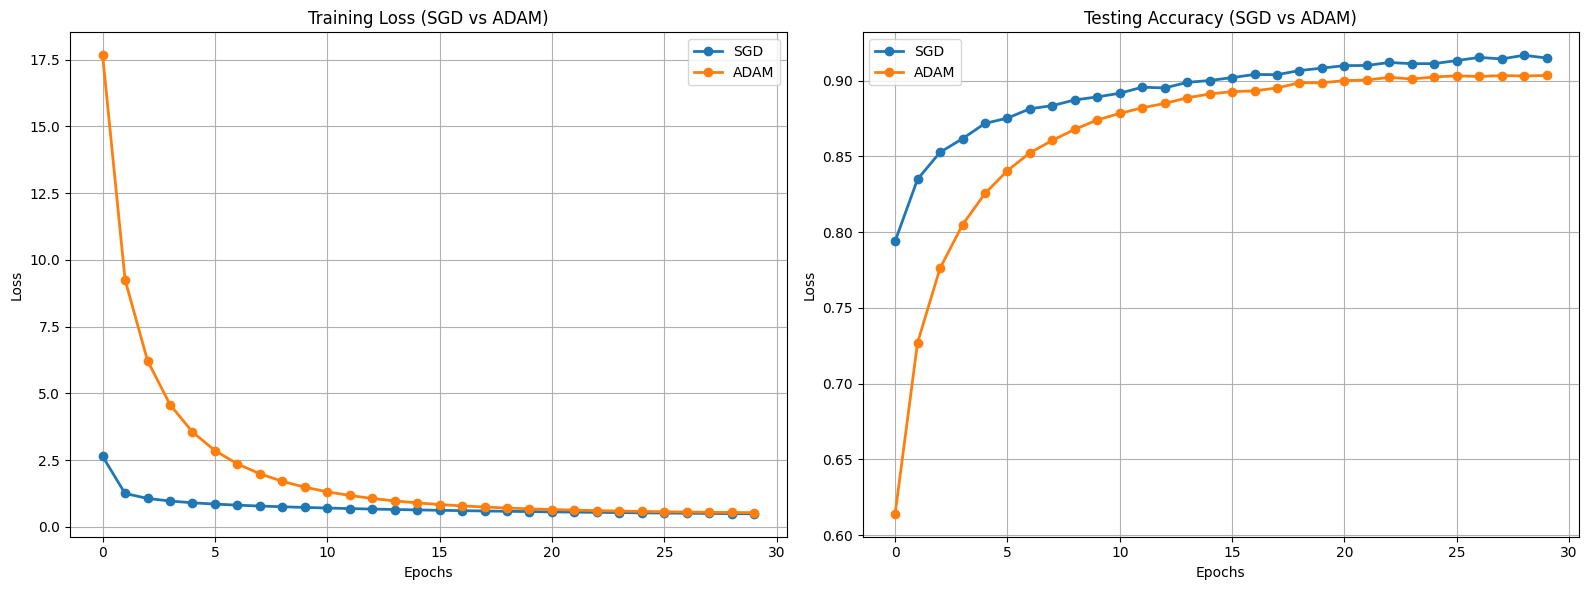

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
epochs_range = list(range(NUM_EPOCHS))  
axes[0].plot(epochs_range, d_alpha_losses_sgd[best_alpha_sgd], label="SGD", marker = "o", linewidth = 2)
axes[0].plot(epochs_range, d_alpha_losses_adam[best_alpha_adam], label="ADAM", marker = "o", linewidth = 2)

axes[1].plot(epochs_range, d_alpha_accuracy_sgd[best_alpha_sgd], label="SGD", marker = "o", linewidth = 2)
axes[1].plot(epochs_range, d_alpha_accuracy_adam[best_alpha_adam], label="ADAM", marker = "o", linewidth = 2)

axes[0].set_title('Training Loss (SGD vs ADAM)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('Testing Accuracy (SGD vs ADAM)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()